In [65]:
# %load_ext autoreload
# %autoreload 2
# set PYTORCH_ENABLE_MPS_FALLBACK=1 in your environment

import os
import sys

sys.path.append("../..")
import seaborn as sns

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import matplotlib.pyplot as plt
import yaml
import lightning_toolbox as ltb
from lightning import seed_everything

seed_everything(4944)
import dypy as dy
from ocd.data import InterventionChainDataset

# create a random permutation of n numbers
n = 10
checkpoint = "epoch=2999-step=108000"

# paths
model_path = "./model-fixed.yml"
data_path = f"./data/chain-{n}-intervention.yml"
checkpoint_path = f"./fixedv7/checkpoints/{n}/{checkpoint}.ckpt"

# configs
data_config = yaml.safe_load(open(data_path, "r"))
model_config = yaml.safe_load(open(model_path, "r"))
model_config["init_args"]["model_args"]["in_features"] = n

# data
dataset = InterventionChainDataset(**data_config["init_args"]["dataset_args"])

# model
model = dy.eval(model_config["class_path"])(**model_config["init_args"])
model.load_state_dict(torch.load(checkpoint_path, map_location="cpu")["state_dict"])
flow = model.model.flow

# hyper params
k = 8
num_interventions = 250
num_samples = 50


values = torch.linspace(-k, k, num_interventions)
with torch.no_grad():
    pred_samples = flow.do(0, values, num_samples=num_samples)
gt_samples = dataset.do(0, values, num_samples=num_samples)
pred_mean = pred_samples.mean(-2)
pred_std = pred_samples.std(-2)
gt_mean = gt_samples.mean(-2)
gt_std = gt_samples.std(-2)


Global seed set to 4944


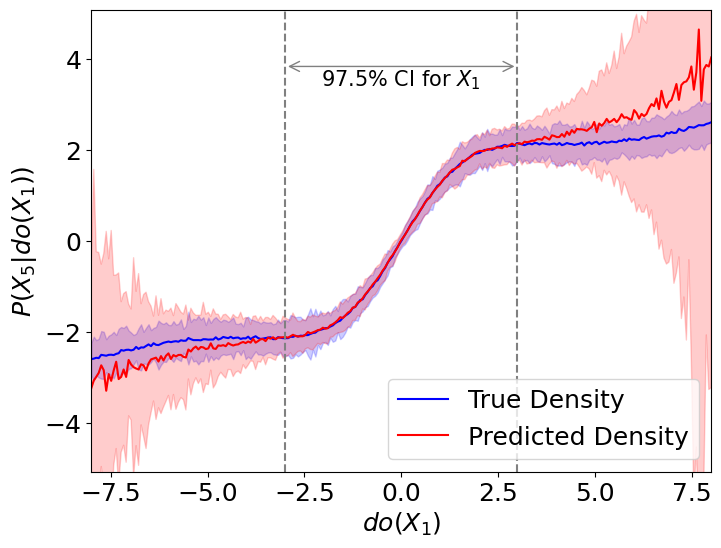

In [73]:

def draw(
    values=None,
    pred_means=None,
    pred_stds=None,
    gt_means=None,
    gt_stds=None,
    target=-1,
    percentile=0.95,
    limit_y=0.9,
    ax=plt
):
    if pred_means is not None:
        pred_mean = pred_means[:, target]
        pred_std = pred_stds[:, target]
    if gt_means is not None:
        gt_mean = gt_means[:, target]
        gt_std = gt_stds[:, target]
    plt.figure(figsize=(8, 6))
    ax.xlim(-k, k)
    ax.xlabel("$do(X_1)$")
    tar = (n + target) if (target < 0) else target
    if gt_means is not None:
        ax.plot(values, gt_mean, label="True Density", color="blue")
        ax.fill_between(values, (gt_mean - 3 * gt_std), (gt_mean + 3 * gt_std), alpha=0.2, color="blue")
    original_limits = ax.ylim()
    if limit_y > 0:
        ax.ylim(abs(original_limits[0]) * (-1 - limit_y), abs(original_limits[1]) * (1 + limit_y))

    ax.ylabel("$P(X_{" + str(tar + 1) + "} | do(X_1))$")
    if pred_means is not None:
        ax.plot(values, pred_mean, label="Predicted Density", color="red")
        ax.fill_between(values, (pred_mean - 3 * pred_std), (pred_mean + 3 * pred_std), alpha=0.2, color="red")
    ax.legend(loc="lower right")
    # ax.grid()
    # based on data.base_distribution compute the 90% confidence interval for values
    # plot the confidence intervals as two vertical lines
    if percentile > 0:
        cis = [(1 - percentile) / 2, 1 - (1 - percentile) / 2]
        icis = dataset.base_distribution.icdf(torch.tensor(cis)).detach().cpu()
        ax.axvline(icis[0].item(), color="gray", linestyle="--")
        ax.axvline(icis[1].item(), color="gray", linestyle="--")
        # label the confidence interval
        # create a horizontal line with two arrows pointing to the vertical lines
        ax.annotate(
            "",
            xy=(icis[0].item(), ax.ylim()[1] - 1.25),
            xytext=(icis[1].item(), ax.ylim()[1] - 1.25),
            arrowprops=dict(arrowstyle="<->", color="gray"),
        )
        # label the confidence interval
        ax.text(
            (icis[0].item() + icis[1].item()) / 2,
            ax.ylim()[1] -1.55,
            f"${cis[1]*100: 0.1f}$% CI for $X_1$",
            horizontalalignment="center",
            verticalalignment="center",
            fontdict={"fontsize": 15},
        )

        # set x ticks to have values at every 2.5 from zero to both sides
        ax.xticks( (-torch.arange(0, k, 2.5)).tolist()[1:][::-1] + torch.arange(0, k, 2.5).tolist())

        # ax.text(
        #     icis[0].item() + 0.1,
        #     ax.ylim()[1] - 3,
        #     f"$X_1$ ${cis[0]*100: 0.1f}$% CI",
        #     rotation=90,
        #     verticalalignment="center",
        #     fontdict={"fontsize": 10},
        # )
        # ax.text(
        #     icis[1].item() + 0.1,
        #     ax.ylim()[1] - 3,
        #     f"$X_1$ ${cis[1]*100: 0.1f}$% CI",
        #     rotation=90,
        #     verticalalignment="center",
        #     fontdict={"fontsize": 10},
        # )
draw(
    values=values,
    pred_means=pred_mean,
    pred_stds=pred_std,
    gt_means=gt_mean,
    gt_stds=gt_std,
    target=4,
    percentile=0.95,
    limit_y=0.5,
)

In [15]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 18})


def draw_interventions_grid(
    targets, values, gt_means, gt_stds, pred_means=None, pred_stds=None, percentile=0.95, limit_y=0.9
):
    nrows = len(targets)
    fig, axs = plt.subplots(1, nrows, figsize=(6 * nrows, 6))  # Adjust the figure size as necessary

    for i, target in enumerate(targets):
        ax = axs[i]
        draw_interventions(
            values=values,
            pred_means=pred_means,
            pred_stds=pred_stds,
            gt_means=gt_means,
            gt_stds=gt_stds,
            target=target,
            percentile=percentile,
            limit_y=limit_y,
            ax=ax,
        )

    plt.tight_layout()
    plt.show()


def draw_interventions(
    values=None,
    pred_means=None,
    pred_stds=None,
    gt_means=None,
    gt_stds=None,
    target=-1,
    percentile=0.95,
    limit_y=0.9,
    ax=None,
):
    if pred_means is not None:
        pred_mean = pred_means[:, target]
        pred_std = pred_stds[:, target]
    if gt_means is not None:
        gt_mean = gt_means[:, target]
        gt_std = gt_stds[:, target]
    ax.set_xlim(-k, k)
    ax.set_xlabel("$do(X_1)$")
    tar = (n + target) if (target < 0) else target
    if gt_means is not None:
        ax.plot(values, gt_mean, label="True Density", color="blue")
        ax.fill_between(values, (gt_mean - 3 * gt_std), (gt_mean + 3 * gt_std), alpha=0.2, color="blue")
    original_limits = ax.get_ylim()
    if limit_y > 0:
        ax.set_ylim(abs(original_limits[0]) * (-1 - limit_y), abs(original_limits[1]) * (1 + limit_y))

    ax.set_ylabel("$P(X_{" + str(tar + 1) + "} | do(X_1))$")
    if pred_means is not None:
        ax.plot(values, pred_mean, label="Predicted Density", color="red")
        ax.fill_between(values, (pred_mean - 3 * pred_std), (pred_mean + 3 * pred_std), alpha=0.2, color="red")
    ax.legend(loc="lower right")
    # ax.grid()
    # based on data.base_distribution compute the 90% confidence interval for values
    # plot the confidence intervals as two vertical lines
    if percentile > 0:
        cis = [(1 - percentile) / 2, 1 - (1 - percentile) / 2]
        icis = dataset.base_distribution.icdf(torch.tensor(cis)).detach().cpu()
        ax.axvline(icis[0].item(), color="gray", linestyle="--")
        ax.axvline(icis[1].item(), color="gray", linestyle="--")
        # label the confidence interval
        ax.text(
            icis[0].item() + 0.1,
            ax.get_ylim()[1] - 3,
            f"$X_1$ ${cis[0]*100: 0.1f}$% CI",
            rotation=90,
            verticalalignment="center",
            fontdict={"fontsize": 10},
        )
        ax.text(
            icis[1].item() + 0.1,
            ax.get_ylim()[1] - 3,
            f"$X_1$ ${cis[1]*100: 0.1f}$% CI",
            rotation=90,
            verticalalignment="center",
            fontdict={"fontsize": 10},
        )


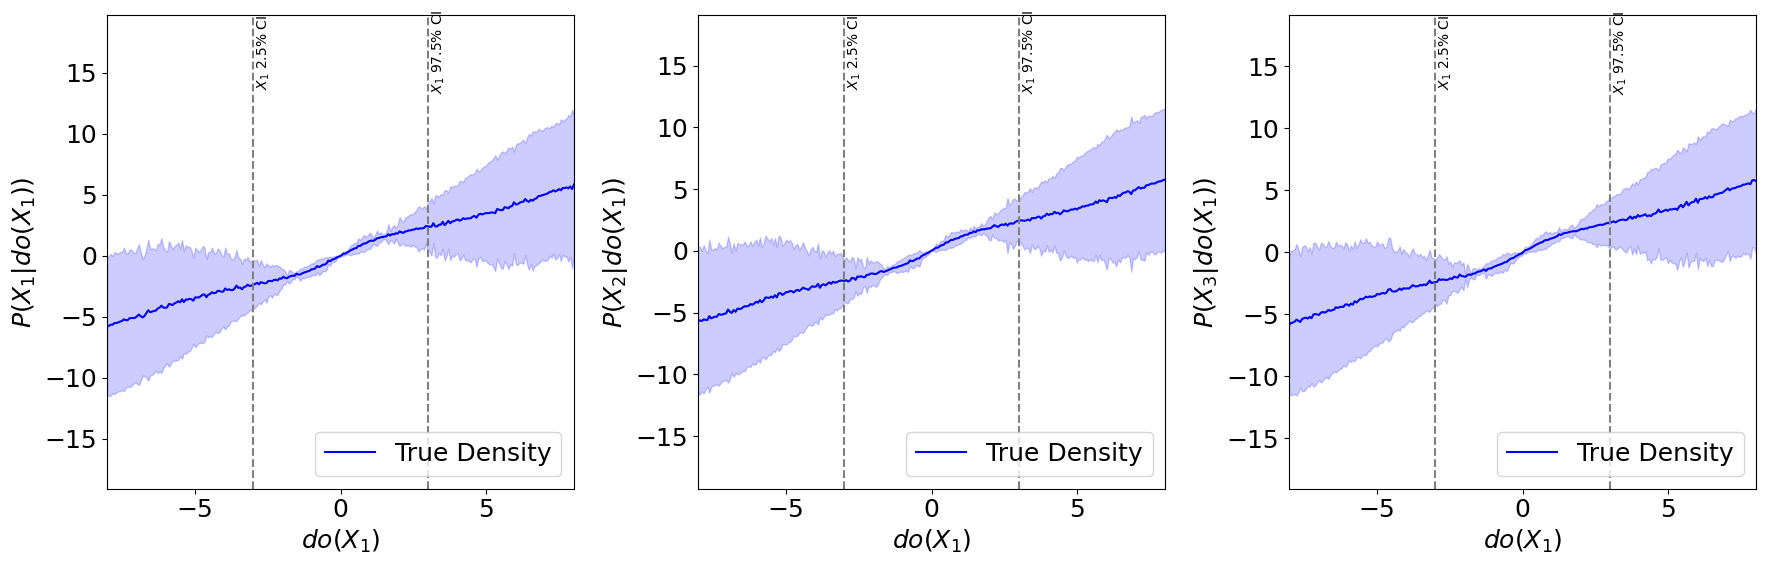

In [78]:
def create_intervention(value):
    def intervention_function(*args, **kwargs):
        return value

    return intervention_function


def scm_intervention(num_samples, value, **kwargs):
    cfg = data_config["init_args"]["dataset_args"]
    cfg = {**cfg, "observation_size": num_samples, "standardization": False}

    data = SyntheticOCDDataset(
        **cfg,
        intervention_nodes=[0],
        intervention_functions=[create_intervention(value)],
    )
    idata = data.samples.to_numpy()
    # print(idata.shape)
    return torch.tensor(idata)


def true_hard_ate(do=0, target=-1, k=1.5, range_samples=1000, num_samples=100, **kwargs):
    values = torch.linspace(-k, k, range_samples)
    ate = torch.stack([scm_intervention(num_samples, value.item(), **kwargs)[:, target] for value in values], dim=0)
    return values, ate.mean(dim=1), ate.std(dim=1)


values, true_ate, true_ate_std = true_hard_ate()
